In [ ]:
!pip install scikit-learn-extra
!pip install larq larq-compute-engine

In [2]:
import larq_compute_engine as lce
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import larq as lq

from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn_extra.cluster import KMedoids
from skimage.transform import resize
from sklearn.utils import shuffle
from google.colab import drive

In [3]:
!mkdir -p "/content/drive/My Drive/LowBeMi"

In [4]:
def clusterSampling(x_train, y_train, imgs_per_class):
  """ Creazione dizionario contenente k immagini per classe campionate utilizzando kMedoids. """
  train_data = dict.fromkeys(np.unique(y_train))

  for k in train_data.keys():
    k_filter = np.where(y_train == k)[0]
    k_images = x_train[k_filter[0:]]
    kmedoids = KMedoids(n_clusters=imgs_per_class).fit(k_images.reshape(len(k_images), -1))
    train_data[k] = kmedoids.cluster_centers_.reshape(imgs_per_class, 28, 28)

  return train_data

In [5]:
def printImages(train_data):
  """ Funzione per la visiaulizzazione di ogni prima immagini per ogni classe. """
  import matplotlib.pyplot as plt

  fig, axes = plt.subplots(1, len(train_data))

  for idx, (key, images) in enumerate(train_data.items()):
      axes[idx].imshow(images[0], cmap='gray')
      axes[idx].set_title(f'Class {key}')
      axes[idx].axis('off')

  plt.tight_layout()
  plt.show()

In [6]:
def preprocessImages(input_data, target_size=(8, 8)):
    """ Funzione per normalizzazione e ridimensionamento delle immagini campionate. """
    preprocessed_data = {}

    for label, images in input_data.items():
        num_images, height, width = images.shape

        flat_images = images.reshape(num_images, -1)
        scaler = MinMaxScaler()
        normalized_images = scaler.fit_transform(flat_images)

        resized_images = []
        for i in range(num_images):
            image = normalized_images[i].reshape(height, width)
            resized_image = resize(image, output_shape=target_size, mode='constant', anti_aliasing=True)
            resized_images.append(resized_image)

        preprocessed_data[label] = np.array(resized_images)

    return preprocessed_data

In [7]:
def getShuffledTrainingData(train_data_dict, i, j, imgs_per_class):
  """ Funzione per la creazione del dataset (i,j) per il training di ogni rete. """
  train_data = np.concatenate((train_data_dict[i], train_data_dict[j]))
  train_labels = np.concatenate(([i] * imgs_per_class, [j] * imgs_per_class))

  train_data, train_labels = shuffle(train_data, train_labels)

  return train_data, train_labels

In [8]:
def BNN(architecture, lr):
  """ Funzione per la creazione di una BNN. """
  input_layer, h1_layer, h2_layer, output_layer = architecture

  model = tf.keras.models.Sequential(
      [
          tf.keras.layers.Flatten(),
          lq.layers.QuantDense(input_layer, kernel_quantizer="ste_sign", kernel_constraint="weight_clip"),
          lq.layers.QuantDense(h1_layer, input_quantizer="ste_sign",
                              kernel_quantizer=lq.quantizers.SteTern(threshold_value=0.05, ternary_weight_networks=True, clip_value=1.0),
                              activation="hard_tanh"),
          lq.layers.QuantDense(h2_layer, input_quantizer="ste_sign",
                              kernel_quantizer=lq.quantizers.SteTern(threshold_value=0.05, ternary_weight_networks=True, clip_value=1.0),
                              activation="hard_tanh"),
          lq.layers.QuantDense(output_layer, input_quantizer="ste_sign",
                              kernel_quantizer=lq.quantizers.SteTern(threshold_value=0.05, ternary_weight_networks=True, clip_value=1.0),
                              activation="hard_tanh")
      ]
  )

  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt,
                loss='squared_hinge',
                metrics=['accuracy'])

  return model

In [9]:
def trainModels(train_data_dict, imgs_per_class):
  """ Funzione per l'addestramento delle singole BNN. """
  classes = train_data_dict.keys()

  for i in range(len(classes)):
    for j in range(i+1, len(classes)):

      print(f"BNN {i}{j}")

      # Crezione dataset (i,j) per addestrare la BNN(i,j)
      train_data, train_labels_ij = getShuffledTrainingData(train_data_dict, i, j, imgs_per_class)

      # Encoding della label
      enc = LabelBinarizer()
      enc.fit(np.unique(train_labels_ij))
      encoded_labels = enc.transform(train_labels_ij)

      earlystopping = tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                      mode="auto", patience=1,
                                                      restore_best_weights=True)

      # Creazione e addestramento della BNN(i,j)
      model = BNN(architecture, lr)
      model.fit(train_data, encoded_labels.flatten(), epochs=5, batch_size=1, callbacks=[earlystopping])

      # Salvataggio del modello in formato .tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(model)
      tflite_model = converter.convert()
      with open(f"/content/drive/My Drive/LowBeMi/model{i}{j}.tflite", "wb") as f:
        f.write(tflite_model)

In [10]:
def predictSingleModel(i, j, test_data):
  bnn_model = tf.lite.Interpreter(f"/content/drive/My Drive/LowBeMi/model{i}{j}.tflite")

  # Allocazione della momeria per ogni modello
  bnn_model.allocate_tensors()

  # Indici per tensori di input e output
  bnn_model_input_index = bnn_model.get_input_details()[0]["index"]
  bnn_model_output_index = bnn_model.get_output_details()[0]["index"]

  bnn_model_predictions = []

  # Run each model's interpreter for each value and store the results in arrays
  for x_value in x_test:
    # Create a 2D tensor wrapping the current x value
    x_value_tensor = tf.convert_to_tensor([x_value], dtype=np.float32)
    # Write the value to the input tensor
    bnn_model.set_tensor(bnn_model_input_index, x_value_tensor)
    # Run inference
    bnn_model.invoke()
    # Read the prediction from the output tensor
    bnn_model_predictions.append(bnn_model.get_tensor(bnn_model_output_index)[0])

  threshold = 0.05
  for p in bnn_model_predictions:
    if p[0] > threshold:
      p[0] = 1
    elif p[0] < -threshold:
      p[0] = -1
    else:
      p[0] = np.nan

  enc = LabelBinarizer()
  enc.fit((i, j))
  predicted_labels = enc.inverse_transform(np.array(bnn_model_predictions))

  return predicted_labels

In [11]:
def predictEnsemble(classes, test_data):
  n_models = 0

  for i in range(len(classes)):
    for j in range(i+1, len(classes)):
      n_models += 1

  single_preds_matrix = np.zeros((n_models, len(test_data)))

  k = 0
  for i in range(len(classes)):
    for j in range(i+1, len(classes)):
      single_preds_matrix[k, :] = predictSingleModel(i, j, test_data)
      k += 1

  ensemble_preds = []

  for k in range(len(test_data)):
    preds, counts = np.unique(single_preds_matrix[:, k], return_counts=True)
    poll = dict(zip(preds, counts))
    ensemble_preds.append(max(poll, key = lambda x: poll[x]))

  return ensemble_preds

In [ ]:
# Download dataset MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Reshape immagini
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

In [13]:
k = 80                        # Numero di immagini per classe
lr = 0.01                     # Learning rate
architecture = [64, 4, 4, 1]  # Architetture delle reti dell'ensemble

# Campionamento delle k immagini per classe tramite kMedoids
data = clusterSampling(train_images, train_labels, k)

# Normalizzazione e ridimensionamento delle immagini
data = preprocessImages(data)

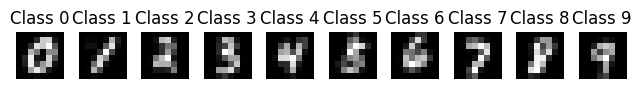

In [14]:
# Visualizzazione della prima immagine di ogni classe
printImages(data)

In [ ]:
# Training dei modelli
trainModels(data, k)

In [16]:
# Conversione dei modelli salvati per
%%bash

for ((i=0; i<10; i++)); do
    for ((j=i+1; j<10; j++)); do
        xxd -i "/content/drive/My Drive/LowBeMi/model${i}${j}.tflite" > "/content/drive/My Drive/LowBeMi/bnn${i}${j}.cc"
    done
done

In [50]:
x_test = [data[0][9], data[1][0], data[2][0], data[3][1], data[4][1], data[5][2],
          data[6][2], data[7][3], data[8][3], data[9][4]]

In [51]:
p = predictEnsemble(data.keys(), x_test)